# Matching lon/lat points to Landsat Path-Rows
## Setups

In [1]:
from google.colab import files, drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Important library for many geopython libraries
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  python3-numpy
Suggested packages:
  python-numpy-doc python3-nose python3-numpy-dbg
The following NEW packages will be installed:
  python3-gdal python3-numpy
0 upgraded, 2 newly installed, 0 to remove and 34 not upgraded.
Need to get 2,288 kB of archives.
After this operation, 13.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 python3-numpy amd64 1:1.13.3-2ubuntu1 [1,943 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python3-gdal amd64 2.2.3+dfsg-2 [346 kB]
Fetched 2,288 kB in 0s (15.6 MB/s)
Selecting previously unselected 

In [3]:
import io
import geopandas as gpd
import shapely.wkt
from shapely.geometry import Point
import urllib.request
import zipfile
import time
import numpy as np
# import kdtree
# from mpi4py import MPI

## Read/Load Data

In [4]:
subsahara = gpd.read_file('drive/MyDrive/detecting-poverty/data/subsahara.geojson').geometry[0]

In [5]:
shapely.geometry.Point(-15.594685, 80.772150) in subsahara

False

In [6]:
url = "https://prd-wret.s3-us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/atoms/files/WRS2_descending_0.zip"
r = urllib.request.urlopen(url)
zip_file = zipfile.ZipFile(io.BytesIO(r.read()))
zip_file.extractall("landsat-path-row")
zip_file.close()
wrs = gpd.read_file('landsat-path-row/WRS2_descending.shp')

In [7]:
!ls landsat-path-row

WRS2_descending.cpg  WRS2_descending.sbn  WRS2_descending.shx
WRS2_descending.dbf  WRS2_descending.sbx  WRS2_descending.xml
WRS2_descending.prj  WRS2_descending.shp


In [8]:
wrs.shape

(28892, 15)

In [9]:
wrs.head(3)

,AREA,PERIMETER,PR_,PR_ID,RINGS_OK,RINGS_NOK,PATH,ROW,MODE,SEQUENCE,WRSPR,PR,ACQDayL7,ACQDayL8,geometry
0,15.74326,26.98611,1.0,1.0,1,0,13,1,D,2233,013001,013001,1,9,"POLYGON ((-10.80341 80.98880, -8.97407 80.3420..."
1,14.55366,25.84254,2.0,2.0,1,0,13,2,D,2234,013002,013002,1,9,"POLYGON ((-29.24250 80.18681, -29.29593 80.198..."
2,13.37247,24.20303,3.0,3.0,1,0,13,3,D,2235,013003,013003,1,9,"POLYGON ((-24.04206 79.12261, -23.78294 79.063..."


### Subset WRS to path/rows that interset with Sub-Saharan Africa

In [10]:
print(wrs.geometry[0])
print(wrs.geometry[0].bounds)
minx, miny, maxx, maxy = wrs.geometry[0].bounds
mean = lambda l: sum(l)/len(l)
print("Centroid %f, %f" % (mean((minx,maxx)), mean((miny,maxy))))

POLYGON ((-10.80341356392465 80.9888, -8.974069999999999 80.342, -9.179187820157681 80.32527435418599, -11.68155289130509 80.12122737355233, -16.17414537600744 79.75489396269606, -16.79342467457441 79.70439690593224, -16.9847 79.6888, -18.84147058372131 80.18684021124938, -19.01989369251518 80.23469851080159, -19.05658048771189 80.24453898295793, -20.58939158639589 80.65568377924396, -21.36442787888292 80.86357119528788, -21.94144300433138 81.01834353899686, -22.1945782978414 81.08624183303475, -22.2153 81.09180000000001, -22.0054624965571 81.1096841708568, -21.78797977351483 81.12821993359449, -21.73012537334796 81.13315078704264, -16.94317356501963 81.54113631212135, -16.44643649320999 81.58347255096038, -13.71618976451242 81.81616784220274, -13.48783815401657 81.83562994573774, -13.2547 81.85550000000001, -13.2360844130473 81.8489180971369, -11.68159448759114 81.29929794725759, -11.41038485572019 81.20340650654987, -10.80341356392465 80.9888))
(-22.2153, 79.6888, -8.97407, 81.8555)


In [11]:
subsahara.intersects(wrs.geometry[1000])

False

In [12]:
wrs.shape

(28892, 15)

In [13]:
# wrs_subset = wrs.sample(1000)
wrs_subsahara = wrs[wrs.geometry.map(lambda g: subsahara.intersects(g))].copy()
wrs_subsahara.shape

(752, 15)

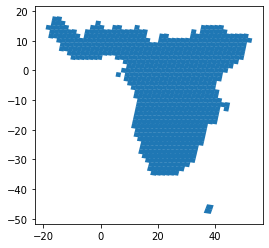

In [14]:
wrs_subsahara.plot()

## Test Rtree querying for matching points to path-rows

In [15]:
wrs_subsahara.reset_index(inplace=True)

In [16]:
wrs_rtree = wrs_subsahara.sindex

In [17]:
i = wrs_rtree.query(Point(2.832204433648292508e+01,3.831549959604480193e+00), predicate='within').item()
print(f"PATH: {wrs_subsahara.PATH[i]}\nROW: {wrs_subsahara.ROW[i]}")

PATH: 174
ROW: 57


# Matching all points

In [18]:
!curl https://detecting-poverty.s3.amazonaws.com/lscale/points.csv -o points.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 48.2M  100 48.2M    0     0  17.7M      0  0:00:02  0:00:02 --:--:-- 17.7M


In [19]:
points = np.loadtxt(
    'points.csv',
    skiprows = 1,
    delimiter = ','
)

In [20]:
points.shape

(1000000, 2)

In [22]:
pathrows = np.empty_like(points)

i = 0
while i < points.shape[0]:
    x, y = points[i,:]
    match = wrs_rtree.query(Point(x,y), predicate='within')[0]#.item()
    if match:
        pathrows[i,:] = wrs_subsahara.PATH[match], wrs_subsahara.ROW[match]
    else:
        pathrows[i,:] = (-1, -1)
    i += 1

In [23]:
pathrows_matches = np.concatenate([points, pathrows], axis=1)

np.savetxt(
    'drive/MyDrive/detecting-poverty/data/point2pathrow.csv',
    pathrows_matches,
    delimiter = ',',
    header = 'lon,lat,path,row'
)